In [ ]:
#importing libraries 
import nltk
import evaluate
import numpy as np
from datasets import load_dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [33]:
# import sys
# print(sys.executable)

In [ ]:

# Downloading dataset
ds = load_dataset("maximedb/natural_questions", trust_remote_code=True)
# Splitting dataset 
ds = ds["train"].train_test_split(test_size= 0.2)


In [22]:
ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 104186
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 26047
    })
})

In [ ]:
# select model 
# MODEL_NAME = "google/flan-t5-base"
MODEL_NAME = "google-t5/t5-small"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# load model
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)  
# Load data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Max sentence length of question: 38
Max sentence length of answer: 823


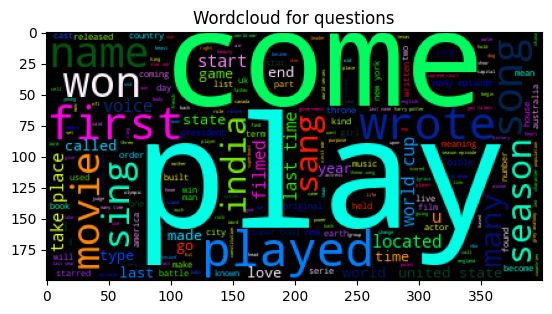

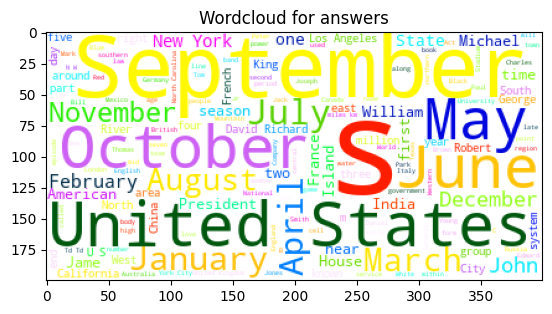

In [ ]:
max_len_q = 0
max_len_a = 0
# Iterating through ds and find max tokens
for item in ds["train"]:
    q_ids = tokenizer.encode(item['question'])
    a_ids = tokenizer.encode(item['answer'])
    max_len_q = max(max_len_q, len(q_ids))
    max_len_a = max(max_len_a, len(a_ids))
    
print(f"Max sentence length of question: {max_len_q}\nMax sentence length of answer: {max_len_a}")


# Generating wordcloud for questions
qns = ""
for item in ds["train"]:
    qns += " " + item['question']
word_cloud = WordCloud(background_color='white', colormap="gist_ncar").generate(qns)
plt.imshow(word_cloud)
plt.title("Wordcloud for questions")
plt.show()

# Generating wordcloud for answers
ans = ""
for item in ds["train"]:
    ans += " " + item['answer']
word_cloud = WordCloud(background_color='white', colormap="gist_ncar").generate(ans)
plt.title("Wordcloud for answers")
plt.imshow(word_cloud)

plt.show()

In [24]:
# We prefix our tasks with "answer the question"
prefix = "Answer this question: "

# Define the preprocessing function

def preprocess_function(examples):
    """Add prefix to the sentences, tokenize the text, and set the labels"""
    # The "inputs" are the tokenized answer:
    inputs = [prefix + doc for doc in examples["question"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    # The "labels" are the tokenized outputs:
    labels = tokenizer(text_target=examples["answer"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [25]:
# Map the preprocessing function across our dataset
tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/104186 [00:00<?, ? examples/s]

Map: 100%|██████████| 26047/26047 [00:01<00:00, 20452.25 examples/s]


In [26]:
# Set up Rouge score for evaluation
# nltk.download("punkt", quiet=True)
metric = evaluate.load("rouge")
meteor_score = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pingj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pingj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pingj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [28]:
import re
import numpy as np

def simple_sent_tokenize(text):
    # A naive sentence tokenizer using regex
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s for s in sentences if s]

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Replace -100 with pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)

    # Decode token IDs to text
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Use naive sentence tokenizer instead of nltk
    decoded_preds = ["\n".join(simple_sent_tokenize(pred)) for pred in decoded_preds]
    decoded_labels = ["\n".join(simple_sent_tokenize(label)) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    meteor_res = meteor_score.compute(predictions=decoded_preds, references=decoded_labels)
    # precision, recall, f1, _ = precision_recall_fscore_support(decoded_labels, decoded_preds, average="weighted")

    return {
            'rouge':result,
            'meteor':meteor_res,
            # 'precision':precision, 
            # 'recall': recall,
            # 'f1': f1,
            }

In [29]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=10, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    # task_type="SEQ_2_SEQ_LM" # FLAN-T5
)

peft_model = get_peft_model(model, lora_config)

In [30]:
# Global Parameters
L_RATE = 3e-4
BATCH_SIZE = 4
# PER_DEVICE_EVAL_BATCH = 2
WEIGHT_DECAY = 0.01
SAVE_TOTAL_LIM = 3
NUM_EPOCHS = 3

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=L_RATE,
    # per_device_train_batch_size=BATCH_SIZE,
    # per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH,
    weight_decay=WEIGHT_DECAY,
    save_total_limit=SAVE_TOTAL_LIM,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    push_to_hub=False,
    logging_dir="./logs",
    logging_steps=1,
)

In [31]:
# Set up trainer
trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\pingj\AppData\Local\Temp\ipykernel_19932\3181277492.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [32]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge,Meteor
1,4.019200,3.732134,"{'rouge1': 0.05473469586172118, 'rouge2': 0.006192704238814568, 'rougeL': 0.05375551142770299, 'rougeLsum': 0.053713953179240985}",{'meteor': 0.0369181623526113}
2,2.497700,3.680872,"{'rouge1': 0.056123084789547306, 'rouge2': 0.006911243076069971, 'rougeL': 0.05513835510375283, 'rougeLsum': 0.05510599087640221}",{'meteor': 0.038381881476289764}
3,4.708100,3.663861,"{'rouge1': 0.05757544807210083, 'rouge2': 0.007042639201972423, 'rougeL': 0.05663007877787142, 'rougeLsum': 0.056600083212422214}",{'meteor': 0.03920533248599887}


TrainOutput(global_step=39072, training_loss=3.9893571021314482, metrics={'train_runtime': 8198.3136, 'train_samples_per_second': 38.125, 'train_steps_per_second': 4.766, 'total_flos': 1790903248257024.0, 'train_loss': 3.9893571021314482, 'epoch': 3.0})

In [ ]:
peft_model.print_trainable_parameters()

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge,Meteor
1,3.038800,2.808671,"{'rouge1': 0.09065554278515837, 'rouge2': 0.020910035534594227, 'rougeL': 0.08894574429163021, 'rougeLsum': 0.08908224130594647}",{'meteor': 0.06441917677899289}
2,2.196300,2.788157,"{'rouge1': 0.09110314795688518, 'rouge2': 0.021867766849236785, 'rougeL': 0.08942928027198242, 'rougeLsum': 0.08960741987696558}",{'meteor': 0.06495903525554858}
3,3.155300,2.776651,"{'rouge1': 0.09366268502913269, 'rouge2': 0.023107689932829748, 'rougeL': 0.09188865313704514, 'rougeLsum': 0.09201423875098197}",{'meteor': 0.06707462212578694}


TrainOutput(global_step=39072, training_loss=3.139088595827567, metrics={'train_runtime': 16121.4385, 'train_samples_per_second': 19.388, 'train_steps_per_second': 2.424, 'total_flos': 9040485033768960.0, 'train_loss': 3.139088595827567, 'epoch': 3.0})

In [48]:
# Trigger the model trainingnatural 512 token length
# trainer.train() 

In [ ]:
# last_checkpoint = "./results/checkpoint-39072" #Flan-T5


In [59]:
def answer_this(model, question):
    # T5-small answer
    tokenizer = AutoTokenizer.from_pretrained(model)
    finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(model)  
    my_question = "what is the disadvantage of AI?"
    inputs = "Answer this question: " + question

    inputs = tokenizer(inputs, return_tensors="pt")
    outputs = finetuned_model.generate(**inputs)
    answer = tokenizer.decode(outputs[0])

    print(f"Answer: {answer}")


In [76]:
last_checkpoint = "./results/checkpoint-26048" #T5-small

In [77]:
question = "what is the disadvantage of AI?"
answer_this(last_checkpoint, question)

Answer: <pad> a lack of a - - - - - - -


In [62]:
question = "what is the capital of China?"
answer_this(last_checkpoint, question)

Answer: <pad> China</s>


In [63]:
question = "where is UK?"
answer_this(last_checkpoint, question)

Answer: <pad> the United States</s>


In [64]:
question = "Who is the most powerful superhero?"
answer_this(last_checkpoint, question)

Answer: <pad> <unk> The Dark Knight ''</s>


In [65]:
question = "YUGBHKL"
answer_this(last_checkpoint, question)

Answer: <pad> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


In [78]:
question = "who is the mother in the how i met your mother?"
answer_this(last_checkpoint, question)

Answer: <pad> a mother</s>


In [79]:
# Loading fintuned Flan-T5
last_checkpoint = "./checkpoint-39072"

tokenizer = AutoTokenizer.from_pretrained(last_checkpoint)
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained(last_checkpoint)  

In [80]:
question = "Who is the most powerful superhero?"
answer_this(last_checkpoint, question)

Answer: <pad> Superman</s>


In [ ]:
question = "what is the disadvantage of AI?"
answer_this(last_checkpoint, question)

Answer: <pad> a lack of a human 's intelligence</s>


In [69]:
question = "travel plan for UK"
answer_this(last_checkpoint, question)

Answer: <pad> a travel plan for the UK</s>


In [ ]:
question = "who is the mother in the how i met your mother?"
answer_this(last_checkpoint, question)

Answer: <pad> Mary</s>


In [ ]:
question = "what is the capital of China?"
answer_this(last_checkpoint, question)

Answer: <pad> Beijing</s>


In [72]:
question = "where is UK?"
answer_this(last_checkpoint, question)

Answer: <pad> England</s>


In [73]:
question = "YUGBHKL"
answer_this(last_checkpoint, question)

Answer: <pad> YUGBHKL</s>


In [3]:
import torch 
torch.version.cuda

'12.4'

In [4]:
import torch
print(torch.__version__)

2.6.0+cu124


In [5]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.52.4', '1.8.1')